In [2]:
from pyspark import SparkConf, SparkContext
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('Top ten restaurant').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
import json

In [3]:
from pyspark.sql.functions import asc, desc
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
text = spark.read.json('archive/yelp_academic_dataset_business.json').repartition(8)

### Top ten rated Restaurant

In [6]:

business = text.select(text.name,text.categories,text.review_count,text.stars)
restaurant = business.filter(business.categories.like('%Restaurants%') | business.categories.like('%Food%'))
restaurant = restaurant.filter(restaurant.review_count >= 100)
restaurant = restaurant.sort(desc('stars'),desc('review_count'))
restaurant.show(20)
restaurant.limit(10).write.csv('topTenRatedRes.csv')

+--------------------+--------------------+------------+-----+
|                name|          categories|review_count|stars|
+--------------------+--------------------+------------+-----+
|     Little Miss BBQ|Barbeque, Restaur...|        2329|  5.0|
|        Brew Tea Bar|Restaurants, Food...|        1827|  5.0|
|     Cocina Madrigal|Restaurants, Mexican|        1107|  5.0|
|Green Corner Rest...|Restaurants, Hala...|         858|  5.0|
|      Worth Takeaway|Breakfast & Brunc...|         842|  5.0|
|      Zenaida's Cafe|Cafes, Breakfast ...|         717|  5.0|
|     Kodo Sushi Sake|Sushi Bars, Resta...|         695|  5.0|
|Bajamar Seafood &...|Fast Food, Dive B...|         658|  5.0|
|              Karved|Restaurants, Sand...|         651|  5.0|
|Not Your Typical ...|Restaurants, Sand...|         645|  5.0|
|        Poke Express|Food, Poke, Hawai...|         591|  5.0|
|       J Karaoke Bar|Nightlife, Bars, ...|         534|  5.0|
|    Simon's Hot Dogs|Latin American, C...|         457

In [ ]:
### Top restaurant in each 

In [7]:
viewRegion = text.select(text.name,text.categories,text.review_count,text.city,text.state,text.stars,text.latitude,text.longitude)
viewRegion = viewRegion.filter(business.categories.like('%Restaurants%') | business.categories.like('%Food%'))
maxReview = viewRegion.groupBy('city').agg({'review_count':'max'})
maxReview = maxReview.sort('max(review_count)',ascending=False)
final = viewRegion.join(maxReview,(maxReview.city == viewRegion.city) & (maxReview['max(review_count)'] == viewRegion.review_count)).drop(maxReview.city).withColumnRenamed('max(review_count)','Max Review')
final = final.sort('Max Review',ascending=False)
final.coalesce(1).write.csv('mostViewedRes',mode='overwrite')
final.show()
vrp = final.select("*").toPandas()
vrp.head(100)

+--------------------+--------------------+------------+-----+-----+-------------+---------------+-------------+----------+
|                name|          categories|review_count|state|stars|     latitude|      longitude|         city|Max Review|
+--------------------+--------------------+------------+-----+-----+-------------+---------------+-------------+----------+
|    Bacchanal Buffet|Sandwiches, Break...|       10129|   NV|  4.0|   36.1159291|   -115.1762385|    Las Vegas|     10129|
|Snooze, An A.M. E...|Breakfast & Brunc...|        3515|   AZ|  4.0|33.5082039543|-112.0370330476|      Phoenix|      3515|
|Pai Northern Thai...|Restaurants, Thai...|        2758|   ON|  4.5|    43.647866|    -79.3886849|      Toronto|      2758|
|          Schwartz's|Sandwiches, Speci...|        2667|   QC|  4.0|    45.516353|     -73.577642|     Montréal|      2667|
|     Studio B Buffet|Desserts, Seafood...|        2456|   NV|  4.0|   35.9650723|   -115.1679801|    Henderson|      2456|
|  Four 

,name,categories,review_count,state,stars,latitude,longitude,city,Max Review
0,Bacchanal Buffet,"Sandwiches, Breakfast & Brunch, Food, Restaura...",10129,NV,4.0,36.115929,-115.176238,Las Vegas,10129
1,"Snooze, An A.M. Eatery","Breakfast & Brunch, Coffee & Tea, Sandwiches, ...",3515,AZ,4.0,33.508204,-112.037033,Phoenix,3515
2,Pai Northern Thai Kitchen,"Restaurants, Thai, Specialty Food, Food, Ethni...",2758,ON,4.5,43.647866,-79.388685,Toronto,2758
3,Schwartz's,"Sandwiches, Specialty Food, Restaurants, Food,...",2667,QC,4.0,45.516353,-73.577642,Montréal,2667
4,Studio B Buffet,"Desserts, Seafood, Specialty Food, Food, Resta...",2456,NV,4.0,35.965072,-115.167980,Henderson,2456
...,...,...,...,...,...,...,...,...,...
95,Oak and Embers Tavern,"Beer Bar, Bars, Nightlife, Restaurants, Barbeque",262,OH,4.0,41.521822,-81.355998,Chesterland,262
96,English Rose Tea Room,"Food, British, Tea Rooms, Restaurants",262,AZ,4.5,33.824936,-111.923786,Carefree,262
97,Primanti Bros,"Chicken Wings, Restaurants, American (Traditio...",255,PA,3.5,40.506615,-80.222705,Moon Township,255
98,Geraci's Restaurant,"Pizza, Italian, Restaurants",255,OH,3.5,41.498216,-81.536786,University Heights,255


In [ ]:
"""review.show(5)
review = text.select(
    review.business_id,
    review.stars)
review = review.withColumn("number",functions.lit(1))
review.show()"""

In [24]:
respd = restaurant.select("*").toPandas()

In [25]:
respd.head(10)

,name,categories,review_count,stars
0,Little Miss BBQ,"Barbeque, Restaurants",2329,5.0
1,Brew Tea Bar,"Restaurants, Food, Cafes, Tea Rooms, Bubble Te...",1827,5.0
2,Cocina Madrigal,"Restaurants, Mexican",1107,5.0
3,Green Corner Restaurant,"Restaurants, Halal, Mediterranean, Sandwiches,...",858,5.0
4,Worth Takeaway,"Breakfast & Brunch, American (Traditional), Am...",842,5.0
5,Zenaida's Cafe,"Cafes, Breakfast & Brunch, Restaurants",717,5.0
6,Kodo Sushi Sake,"Sushi Bars, Restaurants, Japanese",695,5.0
7,Bajamar Seafood & Tacos,"Fast Food, Dive Bars, Bars, Tacos, Seafood, Ni...",658,5.0
8,Karved,"Restaurants, Sandwiches, Fast Food, Salad, Ame...",651,5.0
9,Not Your Typical Deli,"Restaurants, Sandwiches, Delis, Caterers, Cuba...",645,5.0


<AxesSubplot:ylabel='name'>

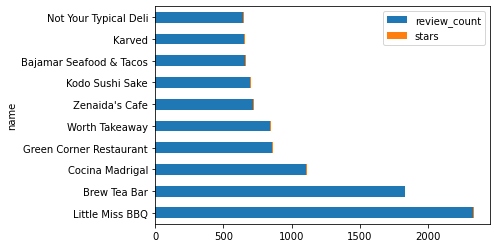

In [24]:
respd.head(10).set_index('name').plot.barh(stacked=True)